In [1]:
# Import necessary packages
from pathlib import Path
import sys
import pandas as pd
from datetime import datetime, timedelta
import re
import numpy as np
import matplotlib.pyplot as plt
import shutil
import hatyan
hatyan.close('all')
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from tqdm import tqdm

In [2]:
# SRL
track1 = Path(r"C:\Users\schijven\OneDrive - Stichting Deltares\Documents\Data\Altimetry_XTRACK_v21\ERS1+ERS2+ENV+SRL\SLA\unpacked_files\ctoh.sla.ref.ERS1+ERS2+ENV+SRL.nea.246.nc")

# S3A
track2 = Path(r"C:\Users\schijven\OneDrive - Stichting Deltares\Documents\Data\Altimetry_XTRACK_v21\S3A\SLA\unpacked_files\ctoh.sla.ref.S3A.nea.001.nc")
track3 = Path(r"C:\Users\schijven\OneDrive - Stichting Deltares\Documents\Data\Altimetry_XTRACK_v21\S3A\SLA\unpacked_files\ctoh.sla.ref.S3A.nea.769.nc")

# GFO
track4 = Path(r"C:\Users\schijven\OneDrive - Stichting Deltares\Documents\Data\Altimetry_XTRACK_v21\GFO\SLA\unpacked_files\ctoh.sla.ref.GFO.nea.104.nc")

# HY2
track5 = Path(r"C:\Users\schijven\OneDrive - Stichting Deltares\Documents\Data\Altimetry_XTRACK_v21\HY2\SLA\unpacked_files\ctoh.sla.ref.HY2.nea.211.nc")

# TP
track6 = Path(r"C:\Users\schijven\OneDrive - Stichting Deltares\Documents\Data\Altimetry_XTRACK_v21\TP+J1+J2+J3\SLA\unpacked_files\ctoh.sla.ref.TP+J1+J2+J3.nea.224.nc")

# TPN
track7 = Path(r"C:\Users\schijven\OneDrive - Stichting Deltares\Documents\Data\Altimetry_XTRACK_v21\TPN+J1N+J2N\SLA\unpacked_files\ctoh.sla.ref.TPN+J1N+J2N.nea.144.nc")

In [5]:
test = Dataset(track7)

print(test["dist_to_coast_gshhs"])
nr = 332

def convert_float_to_datetime(days_array, base_date = datetime(1950, 1, 1)):
    """
    This function converts an array of hours to an array of datetimes. The default reference date is 01/01/1950
    """
    datetime_list = [base_date + timedelta(days=float(days)) for days in days_array]
    return datetime_list
    
# convert_float_to_datetime(test["time"][:][:,nr].flatten())

<class 'netCDF4._netCDF4.Variable'>
float64 dist_to_coast_gshhs(points_numbers)
    units: m
    long_name: Distance to nearest coastline
    scale_factor: -0.01
    comment: Distance to nearest GSHHS 1.3 coastline
unlimited dimensions: 
current shape = (34,)
filling on, default _FillValue of 9.969209968386869e+36 used


In [2]:
file = Path(r"C:\Users\schijven\OneDrive - Stichting Deltares\Documents\Data\ERA-5\full\ERA5_2018.nc")
data = Dataset(file)

lat = data["latitude"][:]                      # Get the latitudes
lon = data["longitude"][:]                     # Get the longitudes
grid_lat, grid_lon = np.meshgrid(lat, lon)     # Create a grid of all latitudes and longitudes
        
# mask Norwegian and Danish coast
m = (60 - 53.5) / (4 - 8.5)               # Define slope of border
b = 53.5 - m * 8.5                   # Define offset of border

# mask western coast of England
h = (57 - 51) / (-4 + 1)                  # Define slope of border
c = 51 - h * -1                      # Define offset of border

# mask Netherlands
n = (53 - 48.5) / (8.5 +1)                # Define slope of border
o = 48.5 - n * -1                    # Define offset of border

lsm = data["lsm"][0]                           # Load land_sea mask
        
# Define complete mask
mask = (grid_lat < 48.5) | (grid_lat > m*grid_lon + b) | (lsm.T > 0.5) | ((grid_lat < 51) & (grid_lon < -1)) | ((grid_lat < h*grid_lon + c) & (grid_lat > 51)) | ((grid_lat <= 53) & (grid_lon >= 5))
p = data["msl"][0]                             # Get example pressure image
u10 = data["u10"][0]
v10 = data["v10"][0]
p[mask.T] = np.nan
u10[mask.T] = np.nan
v10[mask.T] = np.nan
t = data["time"]
datetime(1900, 1, 1) + timedelta(hours=float(t[0]))

datetime.datetime(2018, 1, 1, 0, 0)

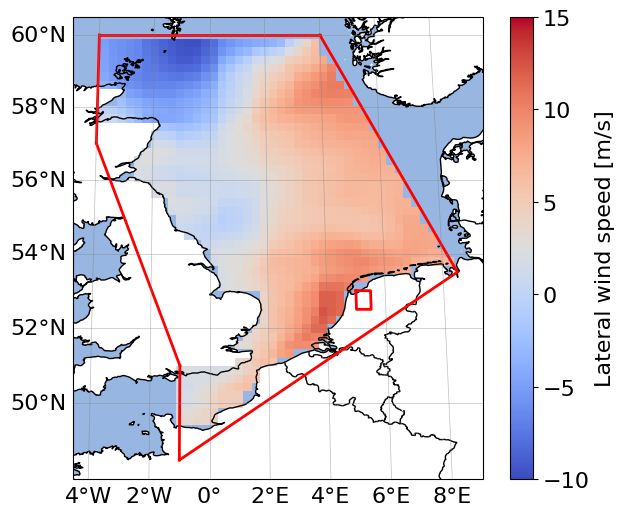

In [6]:
projection_crs = ccrs.Robinson()        # Define projection
fig, ax = plt.subplots(subplot_kw={'projection': projection_crs}, figsize=(7, 6))  # Define figure specs
ax.coastlines(resolution="10m")            # Add coastlines
ax.add_feature(cfeature.BORDERS, edgecolor='k')  # Add borders between countries
ax.add_feature(cfeature.OCEAN)             # Add blue ocean
masked_p = np.ma.masked_where(np.isnan(p), v10) # Mask the nan values
# Plot the image with NaN values masked
# grid = ax.imshow(masked_p[::-1]/100, extent=(grid_lon.min(), grid_lon.max(), grid_lat.min(), grid_lat.max()), cmap='coolwarm', vmin=970, vmax=1005, origin='lower', transform=ccrs.PlateCarree())
grid = ax.imshow(masked_p[::-1], extent=(grid_lon.min(), grid_lon.max(), grid_lat.min(), grid_lat.max()), cmap='coolwarm', vmin=-10, vmax=15, origin='lower', transform=ccrs.PlateCarree())
ax.set_extent([-4.5, 9, 48, 60.5], crs=ccrs.PlateCarree())   # Define extent of plot

# Plot borders of area of interest
x = [-4, 4]
y = [60, 60]
x1 = [8.5, 4]
y1 = [53.5, 60]
x2 = [-1, 8.5]
y2 = [48.5, 53.5]
x3 = [-1, -4]
y3 = [51, 57]
x4 = [-4, -4]
y4 = [60, 57]
x5 = [-1, -1]
y5 = [51, 48.5]
ijx = [5, 5, 5.5, 5.5, 5]
ijy = [53, 52.5, 52.5, 53, 53]
ax.plot(x, y, color='red', linewidth=2, transform=ccrs.PlateCarree())
ax.plot(ijx, ijy, color='red', linewidth=2, transform=ccrs.PlateCarree())
ax.plot(x1, y1, color='red', linewidth=2, transform=ccrs.PlateCarree())
ax.plot(x2, y2, color='red', linewidth=2, transform=ccrs.PlateCarree())
ax.plot(x3, y3, color='red', linewidth=2, transform=ccrs.PlateCarree())
ax.plot(x4, y4, color='red', linewidth=2, transform=ccrs.PlateCarree())
ax.plot(x5, y5, color='red', linewidth=2, transform=ccrs.PlateCarree())

f = 16
cbar = plt.colorbar(grid, ax=ax, orientation='vertical', pad=0.05) # Add colorbar
# cbar.set_label("Pressure [hPa]", fontsize=f)
# cbar.set_label("Longitudinal wind speed [m/s]", fontsize=f)
cbar.set_label("Lateral wind speed [m/s]", fontsize=f)
cbar.ax.tick_params(labelsize=f)
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)  # Add gridlines and labels
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': f}
gl.ylabel_style = {'size': f}


# {"bottom": "x", "left": "y"}